# Градиентный спуск

<img src='https://miro.medium.com/max/1400/1*47skUygd3tWf3yB9A10QHg.gif' width=700>


Сегодня обсудим:
1. Для чего нужен градиентный спуск для нейронных сетей
2. Что такое градиент
3. Что такое градиентный спуск

## Для чего нужен?

Чтобы ответить на данный вопрос, давайте возьмем задачу построения и обучения сети для умножения на 3.

Создадим обучающие данные

In [7]:
import numpy as np

X = np.array([[1], [3], [2], [10], [4], [7], [8]])
y = np.array([[3, 9, 6, 30, 12, 21, 24]]).T

Создадим сеть, она очень простая, состоит из одного слоя и одного нейрона.

<img src='https://drive.google.com/uc?id=1Qx71h2FmXS6uKHmhcIKtp49G5nqMncWK'>

In [8]:
from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf
tf.random.set_seed(0)


model = Sequential([
    Dense(1, input_shape=(1,), activation='linear')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Весов у нас выходит две штуки, это вышло из-за того, что для каждого нейрона в линейном слое есть отклонение (bias).

In [9]:
w1, w0 = model.get_weights()
w1 = w1[0][0]
w0 = w0[0]

w1, w0

(-0.4654894, 0.0)

Теперь сделаем предсказание этой моделью на одном объекте.

In [10]:
X[:1]

array([[1]])

Предсказание получается очень далекими от истины, потому что сеть еще не знает, для чего её создали.

In [11]:
model.predict(X[:1])

1/1 [==============================] - 0s 80ms/step


array([[-0.4654894]], dtype=float32)

In [ ]:
w1 * X[:1] + w0

array([[-0.7206192]])

In [ ]:
from keras.activations import linear
linear(w1 * X[:1] + w0)

array([[-0.7206192]])

Оптимизируем/уменьшаем ошибку MSE - а это функция, которая меняется от весов в нейроне.

Можем взять по 100 разных значений весов и посчитать в них MSE и отобразить на трехмерном графике.

Так же отобразим и веса, которые есть на момент инициализации сети.

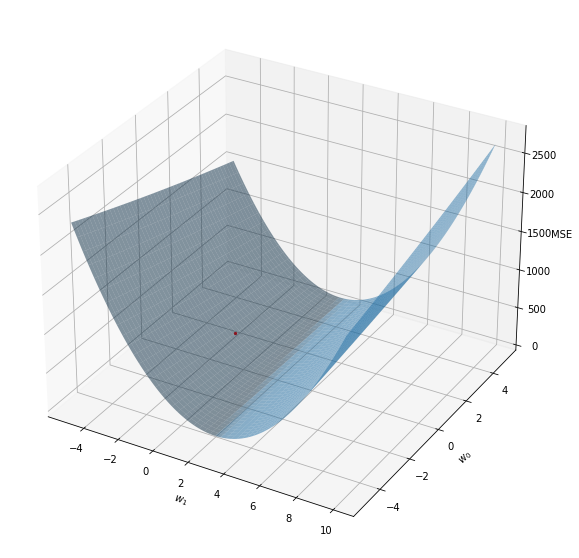

In [12]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt


def mse(w1, w0):
    y_pred = w1 * X[:, 0] + w0
    return np.mean((y - y_pred) ** 2)


coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

zs = np.array([mse(i, j) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

ax.plot_surface(w1s, w0s, Z, alpha=.5)
ax.scatter(w1, w0, mse(w1, w0), c='r', s=5)

ax.set_xlabel(r'$w_1$')
ax.set_ylabel(r'$w_0$')
ax.set_zlabel('MSE')

plt.show()

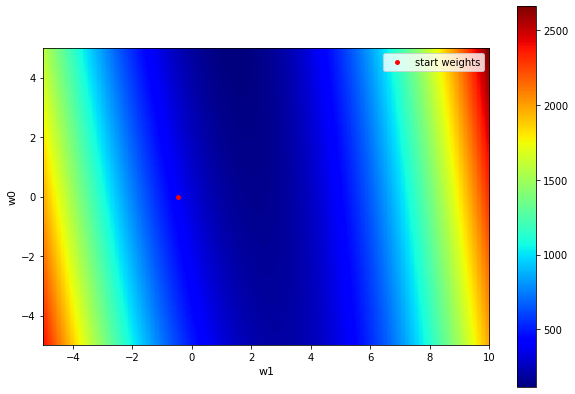

In [13]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()
plt.scatter(w1, w0, c='r', s=15, label='start weights')


plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");

Чтобы оказаться в самой минимальной ошибке нужно до нее дойти, а идти до нее можем с помощью градиентного спуска.

## Градиентный спуск


> **Градиентный спуск** — метод нахождения локального минимума или максимума функции с помощью движения вдоль градиента.

_Градиентом_ функции $f$ называется $n$-мерный вектор из частных производных.

$$ \nabla f(x_{1},...,x_{d}) = \left(\frac{\partial f}{\partial x_{i}}\right)^{d}_{i=1}.$$

К примеру, если функция зависит от трех переменных: $F(x, y, z)$, то её градиент будет равен

$$\nabla f(x, y, z) = (\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}, \frac{\partial f}{\partial z}) $$

При этом, __градиент задает направление наискорейшего роста функции__. Значит, антиградиент будет показывать направление ее скорейшего убывания, что будет полезно нам в нашей задаче минимизации функционала ошибки.

Давайте попробуем реализовать программно градиентный спуск на нашем примере, чтобы лучше понять как он работает.

Функция, которую здесь оптимизируем - это MSE, её график для конкретно нашей задачи рисовали выше.

#### Вручную

Реализуем две функции:
1. mserror - функция среднеквадратичной ошибки $MSE = \frac{1}{n}\sum_{i=0}^n{(\text{y}_i-\text{y_pred}_i})^2 = \frac{1}{n}\sum_{i=0}^n{(\text{y}_i-(w_1\cdot X_i + w_0)})^2 = \frac{1}{n}\sum_{i=0}^n{(\text{y}_i-w_1\cdot X_i - w_0})^2$


2. gr_mserror - градиент функции MSE. Распишем его отдельно для весов:


$w_1$:
$\frac{∂ MSE}{∂ w_1} = \frac{1 \cdot 2}{n}\sum({y_i -\text{y_pred}_i})\cdot -X$

$w_0$:
$\frac{∂ MSE}{∂ w_0} = \frac{1 \cdot 2}{n}\sum({y_i -\text{y_pred}_i})\cdot -1$


In [14]:
# функция, определяющая среднеквадратичную ошибку
def mserror(X, w1, w0, y):
    y_pred = w1 * X[:, 0] + w0
    return np.sum((y - y_pred) ** 2) / len(y_pred)

# функция градиента
def gr_mserror(X, w1, w0, y):
    y_pred = w1 * X + w0
    return {'grad_w1': 2/len(y)*np.sum((y - y_pred) * (-X)),
            'grad_w0': 2/len(y)*np.sum((y - y_pred)) * (-1)}

Перед тем, как считать градиенты и перед тем, как запускать градиентный спуск, давайте посчитаем ошибку

In [15]:
preds = X * w1 + w0
preds

array([[-0.46548939],
       [-1.39646816],
       [-0.93097878],
       [-4.65489388],
       [-1.86195755],
       [-3.25842571],
       [-3.7239151 ]])

In [16]:
import pandas as pd

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

df

,true,pred
0,3,-0.465489
1,9,-1.396468
2,6,-0.930979
3,30,-4.654894
4,12,-1.861958
5,21,-3.258426
6,24,-3.723915


In [17]:
np.mean((df['true'] - df['pred']) ** 2)

416.90526526788784

Инициализация начальной точки

In [18]:
weights_1 = [w1]
weights_0 = [w0]

In [19]:
grad = gr_mserror(X, w1, w0, y)
grad

{'grad_w1': -240.6039774758475, 'grad_w0': -34.65489387512207}

In [20]:
next_w_1 = w1 - grad['grad_w1']
next_w_0 = w0 - grad['grad_w0']

next_w_1, next_w_0

(240.1384880883353, 34.65489387512207)

Получились очень большие веса, давайте посчитаем на них ошибку

In [21]:
preds = X * next_w_1 + next_w_0

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

df

,true,pred
0,3,274.793382
1,9,755.070358
2,6,514.931870
3,30,2436.039775
4,12,995.208846
5,21,1715.624310
6,24,1955.762799


In [22]:
np.mean((df['true'] - df['pred']) ** 2)

2035527.1952643823

Совсем гигантская получилась ошибка, значит что-то пошло не так. А именно пошли не так градиенты, они очень большие, то есть функция растет быстрее, чем она уменьшается в другом направлении.

Чтобы этого избежать можем использовать скорость обучения (learning rate).

> **Скорость обучения** — это параметр градиентных алгоритмов, позволяющий управлять величиной коррекции весов на каждой итерации.

In [23]:
grad = gr_mserror(X, w1, w0, y)
grad

{'grad_w1': -240.6039774758475, 'grad_w0': -34.65489387512207}

In [24]:
lr = 0.01

In [25]:
next_w_1 = w1 - lr * grad['grad_w1']
next_w_0 = w0 - lr * grad['grad_w0']

weights_1.append(next_w_1)
weights_0.append(next_w_0)

next_w_1, next_w_0

(1.940550387246268, 0.3465489387512207)

Получились веса не такие большие, как после первого запуска.

Посчитаем ошибку

In [26]:
preds = X * next_w_1 + next_w_0

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

df

,true,pred
0,3,2.287099
1,9,6.168200
2,6,4.227650
3,30,19.752053
4,12,8.108750
5,21,13.930402
6,24,15.870952


In [27]:
np.mean((df['true'] - df['pred']) ** 2)

35.41306136552762

Движемся в правильном направлении, судя по ошибке.

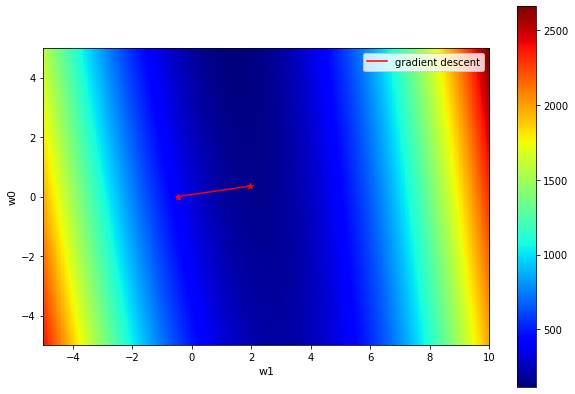

In [28]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()


plt.plot(weights_1, weights_0, label='gradient descent', c='r')
plt.scatter(weights_1, weights_0, marker='*', c='r')

plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");

In [29]:
grad = gr_mserror(X, next_w_1, next_w_0, y)
grad

{'grad_w1': -70.09058372653261, 'grad_w0': -9.901398250034879}

In [30]:
next_w_1 = next_w_1 - lr * grad['grad_w1']
next_w_0 = next_w_0 - lr * grad['grad_w0']

weights_1.append(next_w_1)
weights_0.append(next_w_0)

next_w_1, next_w_0

(2.641456224511594, 0.4455629212515695)

In [31]:
preds = X * next_w_1 + next_w_0

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

np.mean((df['true'] - df['pred']) ** 2)

3.0636359485881046

Движемся в правильном направлении, судя по ошибке.

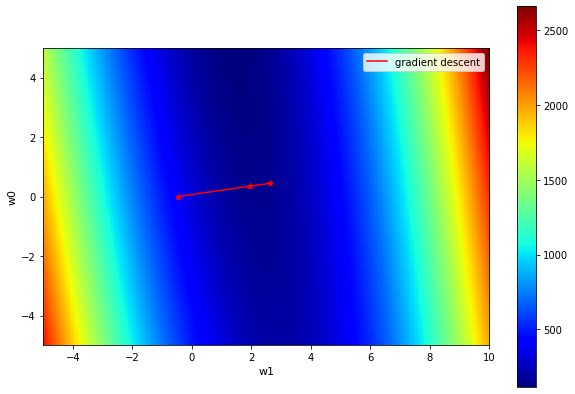

In [32]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()


plt.plot(weights_1, weights_0, label='gradient descent', c='r')
plt.scatter(weights_1, weights_0, marker='*', c='r')

plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");

In [33]:
# количество итерация
n = 100

for i in range(n):
    cur_weight_1 = next_w_1
    cur_weight_0 = next_w_0
    grad = gr_mserror(X, cur_weight_1, cur_weight_0, y)

    next_w_1 = cur_weight_1 - lr * grad['grad_w1']
    next_w_0 = cur_weight_0 - lr * grad['grad_w0']

    weights_1.append(next_w_1)
    weights_0.append(next_w_0)

In [35]:
preds = X * cur_weight_1 + cur_weight_0

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

df

,true,pred
0,3,3.241746
1,9,9.159632
2,6,6.200689
3,30,29.872231
4,12,12.118575
5,21,20.995403
6,24,23.954346


In [36]:
np.mean((df['true'] - df['pred']) ** 2)

0.02238427466192216

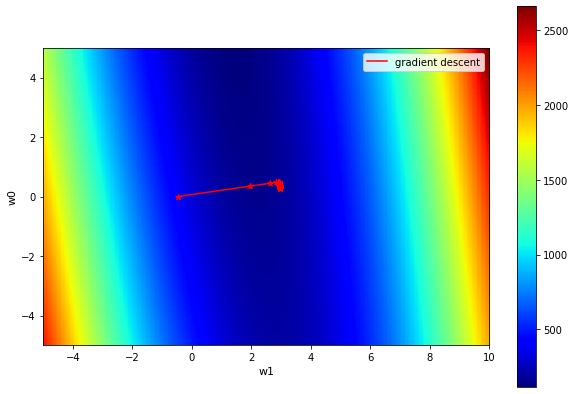

In [37]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()


plt.plot(weights_1, weights_0, label='gradient descent', c='r')
plt.scatter(weights_1, weights_0, marker='*', c='r')

plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");

#### Алгоритм градиентного спуска

1. Инициализация начальной точки
2. Цикл по k = 1,2,3,...:

- $ w_{k} = w_{k-1} - \eta\nabla f(w_{k-1}) $


#### Через Keras

In [38]:
df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(model.predict(X))
})

np.mean((df['true'] - df['pred']) ** 2)

1/1 [==============================] - 0s 21ms/step


416.90526526788784

In [39]:
model.compile(optimizer='sgd', loss='mse', metrics='mae')

In [40]:
model.get_weights()[0][0][0], model.get_weights()[1][0]

(-0.4654894, 0.0)

In [41]:
n_epochs = 10
weights = [[model.get_weights()[0][0][0], model.get_weights()[1][0]]]

for i in range(n_epochs):
    model.fit(X, y)
    weights.append([model.get_weights()[0][0][0], model.get_weights()[1][0]])

weights = np.array(weights)
weights

1/1 [==============================] - 0s 5ms/step - loss: 0.0615 - mae: 0.2130


array([[-0.4654894 ,  0.        ],
       [ 1.9405503 ,  0.34654894],
       [ 2.6414561 ,  0.44556293],
       [ 2.8458316 ,  0.47250608],
       [ 2.905618  ,  0.4784728 ],
       [ 2.9232988 ,  0.47834155],
       [ 2.9287171 ,  0.47644484],
       [ 2.9305634 ,  0.47404423],
       [ 2.9313679 ,  0.471507  ],
       [ 2.9318676 ,  0.46894008],
       [ 2.932277  ,  0.46637452]], dtype=float32)

In [42]:
import pandas as pd

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(model.predict(X))
})

df

1/1 [==============================] - 0s 42ms/step


,true,pred
0,3,3.398652
1,9,9.263206
2,6,6.330928
3,30,29.789145
4,12,12.195482
5,21,20.992313
6,24,23.924591


In [43]:
np.mean((df['true'] - df['pred']) ** 2)

0.060876106186112465

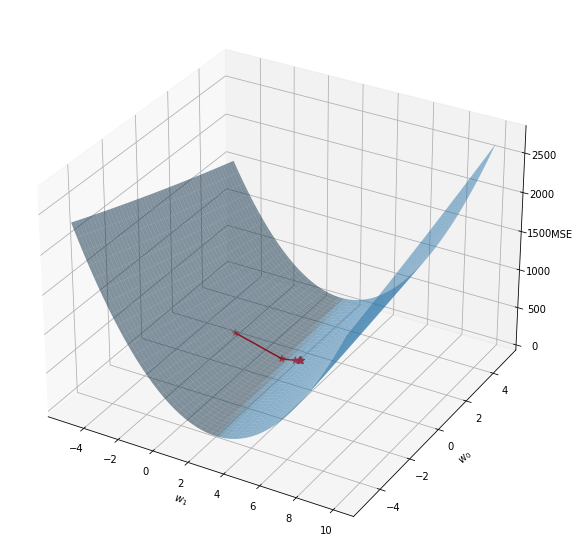

In [44]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

zs = np.array([mse(i, j) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

ax.plot_surface(w1s, w0s, Z, alpha=.5)

mses = []
for weight1, weight0 in weights:
    mses.append(mse(weight1, weight0))

ax.plot(weights[:, 0], weights[:, 1], mses, label='gradient descent', c='r')
ax.scatter(weights[:, 0], weights[:, 1], mses, c='r', marker='*', s=50)


ax.set_xlabel(r'$w_1$')
ax.set_ylabel(r'$w_0$')
ax.set_zlabel('MSE')

plt.show()

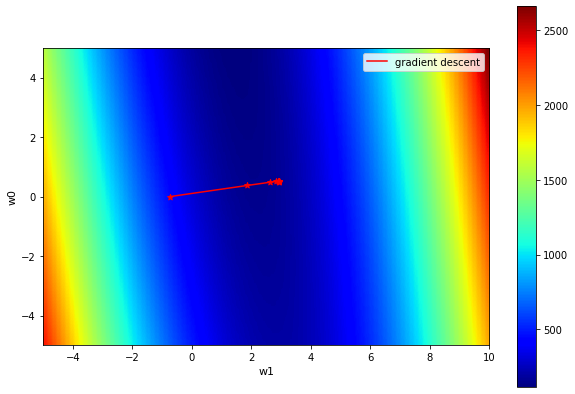

In [ ]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()


plt.plot(weights[:, 0], weights[:, 1], label='gradient descent', c='r')
plt.scatter(weights[:, 0], weights[:, 1], marker='*', c='r')

plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");

## Сеть для классификации чисел

Подгрузим данные из стандартных датасетов из `keras`.

Датасет называется MNIST и представляет из себя черно-белые изображения 28 на 28 пикселей.

In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
X_train[0].shape

(28, 28)

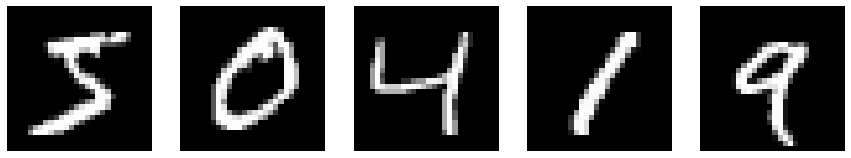

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i in range(5):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].axis('off')

In [ ]:
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

Но давайте упростим себе задачу и возьмем для обучения только два класса, чтобы сделать задачу бинарной классификации.

In [ ]:
idxs = np.where((y_train == 0) | (y_train == 1))
y_train = y_train[idxs]

In [ ]:
X_train = X_train[idxs]

In [ ]:
X_train.shape, y_train.shape

((12665, 28, 28), (12665,))

И тоже самое для теста.

In [ ]:
idxs = np.where((y_test == 0) | (y_test == 1))
y_test = y_test[idxs]

X_test = X_test[idxs]

X_test.shape, y_test.shape

((2115, 28, 28), (2115,))

Убедимся, что теперь у нас только 0, либо 1.

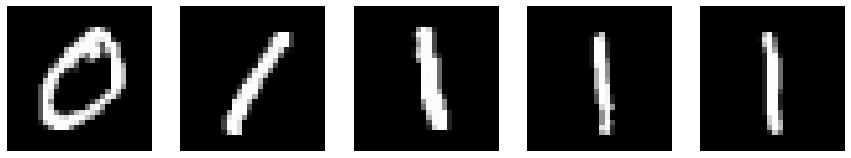

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i in range(5):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].axis('off')

In [ ]:
y_train[:5]

array([0, 1, 1, 1, 1], dtype=uint8)

Нормируем данные, сейчас обойдемся без `MinMaxScaler` из `sklearn`, а воспользуемся делением на 255, т.к. сейчас изображения представлены пикселями в диапазоне от 0 до 255, а для нейросети комфортней обучаться на диапазоне от 0 до 1.

In [ ]:
print(X_train.min(), X_train.max())

X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.min(), X_train.max())

0 255
0.0 1.0


Так же нужно видоизменить метку класса, сейчас это лейблы 0 или 1, нужно преобразовать в бинарный вид.

Тем самым получаем 2 столбика, где первый - это метка является ли изображение 0 классом, а второй столбик - является ли изображение 1 классом.

In [ ]:
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

y_train[:5]

array([0, 1, 1, 1, 1], dtype=uint8)

А чтобы еще легче обучать сетку поменяем масштаб изображений, сейчас они 28 на 28, сделаем меньше, чтобы нейросеть была легче.

In [ ]:
X_train[..., np.newaxis].shape

(12665, 28, 28, 1)

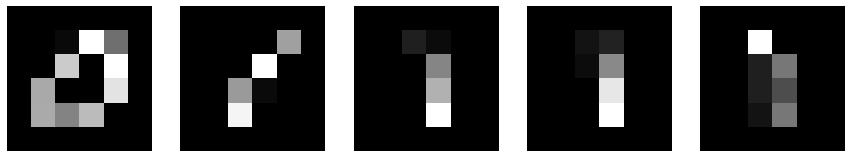

In [ ]:
import matplotlib.pyplot as plt


X_train_resized = tf.image.resize(X_train[..., np.newaxis], (6, 6))[..., 0]
X_test_resized = tf.image.resize(X_test[..., np.newaxis], (6, 6))[..., 0]

fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i in range(5):
    ax[i].imshow(X_train_resized[i], cmap='gray')
    ax[i].axis('off')

Для того, что обучить нейронную сеть для любой задачи нужно ответить на три вопроса:
1. Какая архитектура сети?
2. Что оптимизируем?
3. Как обучаем?

### Архитектура сети

Создадим сеть еще сложнее.

Во-первых, на вход поступает изображение 6х6, нужно с ним что-то сделать, так как наша сетку пока не умеет работать с двумерным входом. Здесь нам поможет слой из `keras` `Flatten`, который вытягивает изображение в один вектор, была картинка 6x6, а станет вектором с размерностью 36.

Во-вторых, на выходе не что-то одно, а две вероятности быть или не быть определенным классом.

А значит на выходе имеем два нейрона, каждый из которых отвечает за класс.

<img src='https://drive.google.com/uc?id=1BQbGhOqu8rgv25QbyHe6qljE-koEm103' width=500>

В-третьих, на выходном слое нужно использовать другую функцию активации, а именно sigmoid, так как она позволяет решать задачу бинарной классификации очень хорошо.

In [ ]:
from keras.layers import Flatten
tf.random.set_seed(9)

model = Sequential([
    Flatten(input_shape=(6, 6)),
    Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 36)                0         
                                                                 
 dense_14 (Dense)            (None, 2)                 74        
                                                                 
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


### Что оптимизируем

У нас задача бинарной классификации, поэтому берем функцию потерь, которая подходит сюда.

Это к примеру, бинарная кросс-энтропия.

In [ ]:
from keras.losses import binary_crossentropy
from keras.optimizers import gradient_descent_v2


optimizer = gradient_descent_v2.SGD(learning_rate=0.1)

In [ ]:
model.compile(optimizer=optimizer, loss=binary_crossentropy, metrics='accuracy')

### Как оптимизируем

Возьмем тот же самый градиентный спуск со стохастикой.

In [ ]:
model.get_weights()

[array([[-0.02625206,  0.20515141],
        [ 0.15866199, -0.19028825],
        [ 0.04804775, -0.1850643 ],
        [ 0.19170305, -0.19234036],
        [ 0.30039033,  0.11250868],
        [ 0.31779346, -0.20720409],
        [-0.10294944, -0.3125878 ],
        [ 0.07605901,  0.00494635],
        [-0.31874323, -0.34759527],
        [ 0.28910723,  0.20623007],
        [ 0.22002223, -0.09159625],
        [ 0.38364133, -0.1958072 ],
        [-0.08515435,  0.03901631],
        [ 0.36431208, -0.2124123 ],
        [ 0.09257811, -0.12456125],
        [ 0.29342452,  0.16001931],
        [ 0.13583079, -0.27644265],
        [ 0.29604736,  0.20738712],
        [-0.13908088,  0.2036986 ],
        [-0.23313044,  0.3609005 ],
        [-0.07937723,  0.02927458],
        [ 0.24387667,  0.19403276],
        [ 0.14424625,  0.38598773],
        [ 0.35373607,  0.03457877],
        [-0.11057925,  0.08136311],
        [-0.370456  ,  0.16501674],
        [-0.10047916,  0.22872892],
        [ 0.08644542,  0.359

Сделаем предсказания

In [ ]:
preds = model.predict(X_train_resized)
preds

array([[0.578898  , 0.6989842 ],
       [0.5725949 , 0.5847321 ],
       [0.59376   , 0.6316246 ],
       ...,
       [0.5833831 , 0.5359133 ],
       [0.5272978 , 0.75691956],
       [0.591508  , 0.5510829 ]], dtype=float32)

И берем метку класса, где максимальная вероятность.

In [ ]:
preds_cls = preds.argmax(axis=1)
preds_cls

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
from sklearn.metrics import accuracy_score

print(f'train acc: {accuracy_score(y_train, preds_cls)*100:.2f}% ({(y_train == preds_cls).sum()} out of {y_train.shape[0]})')

train acc: 42.85% (5427 out of 12665)


In [ ]:

for i in range(1):
    with tf.GradientTape() as tape:
        pred = model(X_train_resized)

        loss_value = binary_crossentropy(y_train_cat, pred)

        grads = tape.gradient(loss_value, model.trainable_weights)
        print('Grad are', grads)
        print('_' * 40)

    optimizer.apply_gradients(zip(grads, model.trainable_weights))

Grad are [<tf.Tensor: shape=(36, 2), dtype=float32, numpy=
array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.06907308e-01,  1.44325793e-01],
       [ 6.27278909e-02,  1.17030069e-02],
       [ 1.43852901e+00, -9.11852837e-01],
       [ 2.53330395e-02, -1.71180237e-02],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 4.31666411e-02, -3.13431136e-02],
       [-2.79370880e+01,  3.46421356e+01],
       [-5.17644165e+02,  6.84729675e+02],
       [-6.13804436e+01,  8.35806702e+02],
       [-3.53455353e+02,  6.46610046e+02],
       [-4.79129672e-01,  7.38613486e-01],
       [ 3.22632156e-02, -9.42432508e-03],
       [-3.63771118e+02,  4.73107941e+02],
       [-6.32297241e+02,  1.00391003e+03],
       [ 1.09438135e+03, -5.99712646e+02],
       [-8.23283203e+02,  1.14892041e+03],
       [-2.47843027e+00,  3.50972915e+00],
       [ 1.38375506e-01, -1.00517012e-01],
       [-8.32376038e+02,  1.15679346e+03],
       [ 3.02872437e+02, -1.04564407e+02],
       [ 3.11782593e+02, -1.10829041e+

Сделаем предсказания

In [ ]:
preds = model.predict(X_train_resized)
preds

array([[1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 9.9890216e-38],
       [1.3185417e-32, 0.0000000e+00],
       ...,
       [0.0000000e+00, 4.4311802e-31],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00]], dtype=float32)

И берем метку класса, где максимальная вероятность.

In [ ]:
preds_cls = preds.argmax(axis=1)
preds_cls

array([0, 1, 0, ..., 1, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score

print(f'train acc: {accuracy_score(y_train, preds_cls)*100:.2f}% ({(y_train == preds_cls).sum()} out of {y_train.shape[0]})')

train acc: 59.49% (7535 out of 12665)


Еще одну итерацию проведем

In [ ]:
for i in range(1):
    with tf.GradientTape() as tape:
        pred = model(X_train_resized)

        loss_value = binary_crossentropy(y_train_cat, pred)

        grads = tape.gradient(loss_value, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights))

Сделаем предсказания

In [ ]:
preds = model.predict(X_train_resized)
preds

array([[1.0000000e+00, 2.5717719e-23],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       ...,
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00]], dtype=float32)

И берем метку класса, где максимальная вероятность.

In [ ]:
preds_cls = preds.argmax(axis=1)
preds_cls

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
print(f'train acc: {accuracy_score(y_train, preds_cls)*100:.2f}% ({(y_train == preds_cls).sum()} out of {y_train.shape[0]})')

train acc: 97.65% (12368 out of 12665)


Сравним предсказания для тестовых данных

In [ ]:
preds = model.predict(X_test_resized)
preds

array([[0., 1.],
       [1., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 1.],
       [0., 1.]], dtype=float32)

И берем метку класса, где максимальная вероятность.

In [ ]:
preds_cls = preds.argmax(axis=1)
preds_cls

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
print(f'test acc: {accuracy_score(y_test, preds_cls)*100:.2f}% ({(y_test == preds_cls).sum()} out of {y_test.shape[0]})')

test acc: 98.39% (2081 out of 2115)


И благо можем не руками проводить обучение, а пользоваться методом fit в keras

Можем одновременно прогонять модель на обучающих данных, на которых будут меняться веса и на тестовых, чтобы проверять качество работы сети.

In [ ]:
%%time
model.fit(X_train_resized, y_train_cat,
          validation_data=(X_test_resized, y_test_cat),
          epochs=1)

396/396 [==============================] - 2s 3ms/step - loss: 21.3351 - accuracy: 0.8865 - val_loss: 17.6359 - val_accuracy: 0.8936
CPU times: user 1.67 s, sys: 54.4 ms, total: 1.73 s
Wall time: 3.1 s


## Summary

Сегодня обсудили:
1. Для чего нужен градиентный спуск
    - GD - это метод оптимизации
    - Нужен для обучения нейронных сетей
2. Что такое градиент
    - Вектор, показывающий направление наискорейшего роста
3. Как написать свой градиентный спуск
    1. Инициализация начальной точки
    2. Цикл по k = 1,2,3,...:
$$ w_{k} = w_{k-1} - \eta\nabla f(w_{k-1}) $$
